## NOTE: Very little augmentation is done for this prototype (only brightness is altered), and only 3 songs are used for training (dear-doppelganger-advanced-12-played, mkdr-basic-15-played, umaru-expert-15-played)

In [1]:
import tensorflow as tf
from tensorflow.python.data import AUTOTUNE
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as SequentialModel
# import keras_tuner as kt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import itertools

import os
# import time

from pathlib import Path

from datasets import dataset_labels_to_dataframe

tf.random.set_seed(5263)
tf.__version__

'2.14.0'

In [2]:
image_shape = (400, 400, 3)
dataset_path = Path("") / "datasets" / "data" / "FiNALE set 1"

eval_dataset_path = Path("") / "datasets" / "data" / "EVAL-perfect-human-expert-15-played"

df = dataset_labels_to_dataframe(dataset_path, "8_zone_presence_labels.csv")
eval_df = dataset_labels_to_dataframe(eval_dataset_path, "8_zone_presence_labels.csv")
# Dataset size
len(df.index)

C:\Users\Zestyy\OneDrive - MMU\Programming\Python\Tensorflow\WA.M.AI\datasets\data\dataframe_builder.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_path = (data_folder / row[0]).resolve()
C:\Users\Zestyy\OneDrive - MMU\Programming\Python\Tensorflow\WA.M.AI\datasets\data\dataframe_builder.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_path = (data_folder / row[0]).resolve()
C:\Users\Zestyy\OneDrive - MMU\Programming\Python\Tensorflow\WA.M.AI\datasets\data\dataframe_builder.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will

6350

In [3]:
file_names = df["file_name"].values
eval_file_names = eval_df["file_name"].values

file_names[0]

'C:\\Users\\Zestyy\\OneDrive - MMU\\Programming\\Python\\Tensorflow\\WA.M.AI\\datasets\\data\\FiNALE set 1\\dear-doppelganger-advanced-12-played\\dear-doppelganger-advanced-12-played-0000000000.png'

In [4]:
labels = df.drop("file_name", axis=1)
eval_labels = eval_df.drop("file_name", axis=1)

labels.head()

,b1,b2,b3,b4,b5,b6,b7,b8
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [5]:
# Initially loading dataset with paths - will be replaced with image source retroactively
dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
eval_dataset = tf.data.Dataset.from_tensor_slices((eval_file_names, eval_labels))
# Shuffle whole dataset before loading images
dataset.shuffle(buffer_size=dataset.cardinality(), reshuffle_each_iteration=True)
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.bool, name=None))>

Dataset info for labels are correct

In [6]:
# Normalise image values to 0-1 from 0-255, and ensure all images are 400x400
IMG_SIZE = (400, 400, 3)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.Rescaling(1./255)
])

def read_image(image_path, labels):
    # Read data from file path and resize to 400x400
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = resize_and_rescale(image)
    # `decode_png` does not state the size of the image, so we force it here`
    # image.set_shape([400, 400, 3])
    # In a normal dataset, the first dimension states how many samples are in the set. 
    # Since teach tensor set here represents 1 sample, we insert a new dimension (which will have length 1) 
    # to state that there is 1 sample
    image = tf.expand_dims(image, 0)
    labels = [labels]
    
    return image, labels

dataset = dataset.map(read_image)
eval_dataset = eval_dataset.map(read_image)
# val_ds = val_ds.map(read_image)
# train_ds
dataset

<_MapDataset element_spec=(TensorSpec(shape=(1, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 8), dtype=tf.bool, name=None))>

In [7]:
# https://www.tensorflow.org/tutorials/images/data_augmentation
def augment(image_label, seed):
  image, label = image_label
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [8]:
rng = tf.random.Generator.from_seed(5263, alg='philox')

# Create a wrapper function for updating seeds.
# @tf.function
def augment_with_seed(image, label):
  seed = rng.make_seeds(2)[0]
  image, label = augment((image, label), seed)
  return image, label
## raises `OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed.`
dataset = dataset.map(augment_with_seed, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

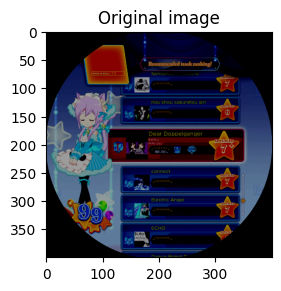

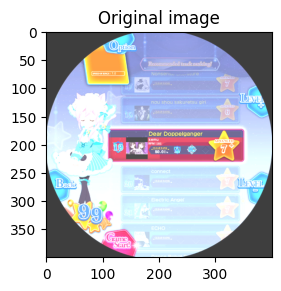

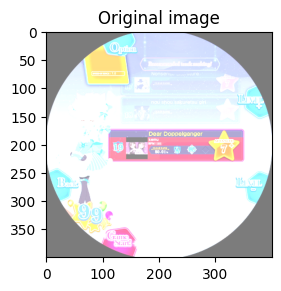

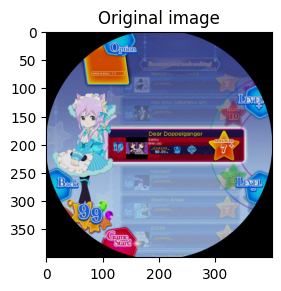

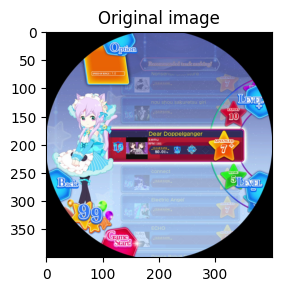

In [9]:
# Visualise the first 5 items in the dataset to ensure that augmentation works as expected
def visualize(original):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

items = dataset.take(5)

for i in items.as_numpy_iterator():
    visualize(i[0][0])

In [10]:
wamai_model = SequentialModel([
    
    # layers.InputLayer(input_shape=(400, 400, 3)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 2, input_shape = image_shape),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 128, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Flatten(),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 8),
    layers.Activation('sigmoid')

])

wamai_model = tf.keras.models.load_model("models/WA.M.AI FiNALE proto 1 cotd/WA.M.AI-p-finale-epoch08-l10.17-acc0.3750.keras")

wamai_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 199, 199, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 199, 199, 32)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 199, 199, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 99, 99, 64)        18496     
                                                                 
 activation_15 (Activation)  (None, 99, 99, 64)        0         
                                                                 
 batch_normalization_9 (Bat  (None, 99, 99, 64)        256       
 chNormalization)                                     

In [11]:
wamai_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',  
                    metrics=["accuracy"])

In [12]:
model_folder = Path("") / "models" / "WA.M.AI FiNALE proto 1 cotd 2"
# model_folder_string = str(model_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

checkpoint_filepath = str(model_folder / "WA.M.AI-p-finale-epoch{epoch:02d}-l{val_loss:.2f}-acc{val_accuracy:.4f}.keras")

# Save a new model every time it improves
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath=checkpoint_filepath,
    save_best_only=False)
# Stop training once the model has not improved on the validation dataset for 7 epochs
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=7)

wamai_model.fit(dataset, epochs=1000, callbacks=[model_checkpoint_callback], validation_data=eval_dataset)
# wamai_model.fit(eval_dataset, epochs=1, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/1000
6350/6350 [==============================] - 486s 76ms/step - loss: 0.0816 - accuracy: 0.4773 - val_loss: 5.0342 - val_accuracy: 0.3438
Epoch 2/1000
6350/6350 [==============================] - 471s 74ms/step - loss: 0.0814 - accuracy: 0.4720 - val_loss: 42.3370 - val_accuracy: 0.3594
Epoch 3/1000
6350/6350 [==============================] - 467s 74ms/step - loss: 0.0737 - accuracy: 0.4934 - val_loss: 6.8229 - val_accuracy: 0.3867
Epoch 4/1000
6350/6350 [==============================] - 474s 75ms/step - loss: 0.0677 - accuracy: 0.4762 - val_loss: 14.8234 - val_accuracy: 0.3516
Epoch 5/1000
6350/6350 [==============================] - 464s 73ms/step - loss: 0.0716 - accuracy: 0.4844 - val_loss: 7.4861 - val_accuracy: 0.3945
Epoch 6/1000
6350/6350 [==============================] - 474s 75ms/step - loss: 0.0606 - accuracy: 0.4901 - val_loss: 6.2416 - val_accuracy: 0.3398
Epoch 7/1000
6350/6350 [==============================] - 470s 74ms/step - loss: 0.0591 - accuracy: 0.47

KeyboardInterrupt: 